In [1]:
import sys
sys.path.append("..")

## Libraries

In [2]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn

## Load the data

In [3]:
from utils.helper import *

In [4]:
df = pd.read_csv("../data/Final_Btc_Data_with_Indicators.csv", parse_dates=['Date'])

df = scaled_data_vmd(df)

target_col = "Price"
features = [col for col in df.columns if col != target_col and col != "Date"]

seq_len = 15
horizon = 1
X, y = create_sequences(df[features].values, df[target_col].values, seq_len, horizon)

## Dataloaders

In [5]:
batch_size = 256

train_loader, val_loader, test_loader = data_loaders(df, X, y, batch_size=batch_size)

In [6]:
input, output = next(iter(train_loader))

input.shape

torch.Size([256, 15, 70])

# LSTM

In [7]:
# torch.Size([256, 5, 14]) -> [B, T, F]
# torch.Size([256])        -> [B]

In [8]:
class BaselineLSTM(nn.Module):
    def __init__(self, input_dim, hidden1=64, hidden2=32, dropout=0.2):
        super().__init__()
        self.lstm1 = nn.LSTM(input_size=input_dim, hidden_size=hidden1, batch_first=True)
        self.drop1 = nn.Dropout(dropout)
        self.lstm2 = nn.LSTM(input_size=hidden1, hidden_size=hidden2, batch_first=True)
        self.fc = nn.Linear(hidden2, 1)

    def forward(self, x):
        # x: (B, T, F)
        out, _ = self.lstm1(x)
        out = self.drop1(out)
        out, _ = self.lstm2(out)

        # take last time step
        out = out[:, -1, :]
        out = self.fc(out)
        return out.squeeze(-1)    # (B,)

In [9]:
lstm = BaselineLSTM(input_dim=len(features))

In [10]:
# Device
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

device

device(type='mps')

In [11]:
# Training the model using the train_loader, val_loader, and test_loader
lstm = lstm.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=0.001)

num_epochs = 300
best_val_loss = float('inf')
patience = 10
patience_counter = 0

train_losses = []
val_losses = []

print(f"Training on device: {device}")
print(f"Model parameters: {sum(p.numel() for p in lstm.parameters())}")

for epoch in range(num_epochs):

    print(f"{'='*40}")
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"{'-'*40}")

    lstm.train()
    train_loss = 0.0

    for batch_x, batch_y in tqdm(train_loader):
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = lstm(batch_x)
        loss = criterion(outputs, batch_y)

        # Backward pass
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    lstm.eval()
    val_loss = 0.0

    with torch.no_grad():
        for batch_x, batch_y in tqdm(val_loader):
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            outputs = lstm(batch_x)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(lstm.state_dict(), '../models/lstm15.pth')
    else:
        patience_counter += 1

    # if epoch % 10 == 0 or epoch == num_epochs - 1:
    print(f'Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}')

    # Early stopping check
    if patience_counter >= patience:
        print(f'Early stopping triggered after epoch {epoch+1}')
        break

print(f'\nBest validation loss: {best_val_loss:.6f}')

Training on device: mps
Model parameters: 47393
Epoch 1/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00,  6.62it/s]


Epoch [1/300] - Train Loss: 1.139382, Val Loss: 18.210215
Epoch 2/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 271.45it/s]


Epoch [2/300] - Train Loss: 0.850308, Val Loss: 16.138050
Epoch 3/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 261.81it/s]


Epoch [3/300] - Train Loss: 0.652164, Val Loss: 13.495498
Epoch 4/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 269.91it/s]


Epoch [4/300] - Train Loss: 0.498713, Val Loss: 10.718960
Epoch 5/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 230.76it/s]


Epoch [5/300] - Train Loss: 0.392882, Val Loss: 8.684148
Epoch 6/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 268.71it/s]


Epoch [6/300] - Train Loss: 0.307157, Val Loss: 7.432281
Epoch 7/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 246.48it/s]


Epoch [7/300] - Train Loss: 0.248637, Val Loss: 6.344869
Epoch 8/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 276.09it/s]


Epoch [8/300] - Train Loss: 0.195730, Val Loss: 5.286566
Epoch 9/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 276.86it/s]


Epoch [9/300] - Train Loss: 0.153026, Val Loss: 4.385872
Epoch 10/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 277.20it/s]


Epoch [10/300] - Train Loss: 0.119964, Val Loss: 3.799342
Epoch 11/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 256.91it/s]


Epoch [11/300] - Train Loss: 0.100128, Val Loss: 3.271404
Epoch 12/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 269.64it/s]


Epoch [12/300] - Train Loss: 0.085516, Val Loss: 2.962418
Epoch 13/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 269.47it/s]


Epoch [13/300] - Train Loss: 0.074592, Val Loss: 2.669063
Epoch 14/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 269.03it/s]


Epoch [14/300] - Train Loss: 0.065941, Val Loss: 2.750764
Epoch 15/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 290.27it/s]


Epoch [15/300] - Train Loss: 0.057696, Val Loss: 2.612688
Epoch 16/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 250.29it/s]


Epoch [16/300] - Train Loss: 0.051654, Val Loss: 2.763427
Epoch 17/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 279.56it/s]


Epoch [17/300] - Train Loss: 0.047316, Val Loss: 2.284637
Epoch 18/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 264.31it/s]


Epoch [18/300] - Train Loss: 0.042720, Val Loss: 3.003617
Epoch 19/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 264.52it/s]


Epoch [19/300] - Train Loss: 0.036658, Val Loss: 2.259770
Epoch 20/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 277.81it/s]


Epoch [20/300] - Train Loss: 0.033470, Val Loss: 2.981192
Epoch 21/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 266.25it/s]


Epoch [21/300] - Train Loss: 0.027591, Val Loss: 2.230335
Epoch 22/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 282.25it/s]


Epoch [22/300] - Train Loss: 0.024210, Val Loss: 2.745726
Epoch 23/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 259.64it/s]


Epoch [23/300] - Train Loss: 0.021652, Val Loss: 2.349110
Epoch 24/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 269.94it/s]


Epoch [24/300] - Train Loss: 0.019388, Val Loss: 2.612368
Epoch 25/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 280.55it/s]


Epoch [25/300] - Train Loss: 0.017509, Val Loss: 2.461005
Epoch 26/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 260.01it/s]


Epoch [26/300] - Train Loss: 0.016291, Val Loss: 2.522933
Epoch 27/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 278.98it/s]


Epoch [27/300] - Train Loss: 0.014955, Val Loss: 2.526677
Epoch 28/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 255.98it/s]


Epoch [28/300] - Train Loss: 0.014419, Val Loss: 2.491864
Epoch 29/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 269.98it/s]


Epoch [29/300] - Train Loss: 0.013959, Val Loss: 2.583029
Epoch 30/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 280.15it/s]


Epoch [30/300] - Train Loss: 0.014574, Val Loss: 2.406615
Epoch 31/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 271.95it/s]

Epoch [31/300] - Train Loss: 0.017951, Val Loss: 3.030901
Early stopping triggered after epoch 31

Best validation loss: 2.230335


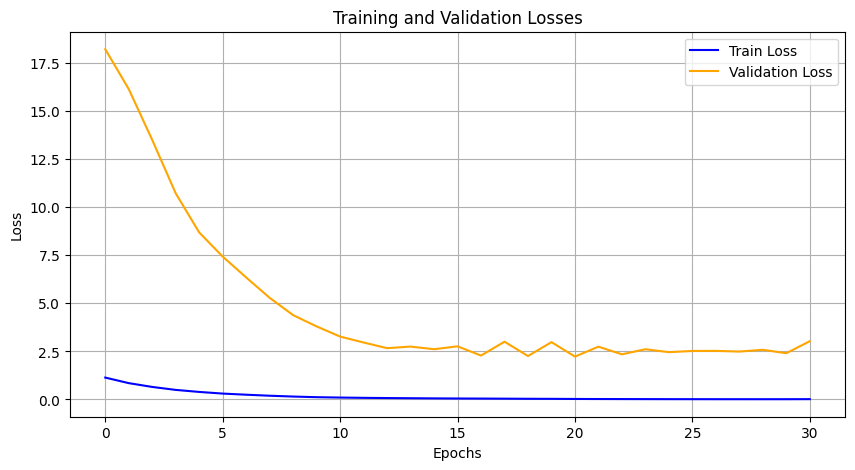

In [12]:
import matplotlib.pyplot as plt

# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid()
plt.show()

In [15]:
# Load best model for testing
lstm.load_state_dict(torch.load('../models/lstm15.pth'))

<All keys matched successfully>

In [13]:
# Test phase
lstm.eval()
test_loss = 0.0
test_predictions = []
test_targets = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        outputs = lstm(batch_x)
        loss = criterion(outputs, batch_y)
        test_loss += loss.item()

        test_predictions.extend(outputs.cpu().numpy())
        test_targets.extend(batch_y.cpu().numpy())

avg_test_loss = test_loss / len(test_loader)
print(f'Test Loss: {avg_test_loss:.6f}')

# Convert to numpy arrays for analysis
test_predictions = np.array(test_predictions)
test_targets = np.array(test_targets)

Test Loss: 1.171367


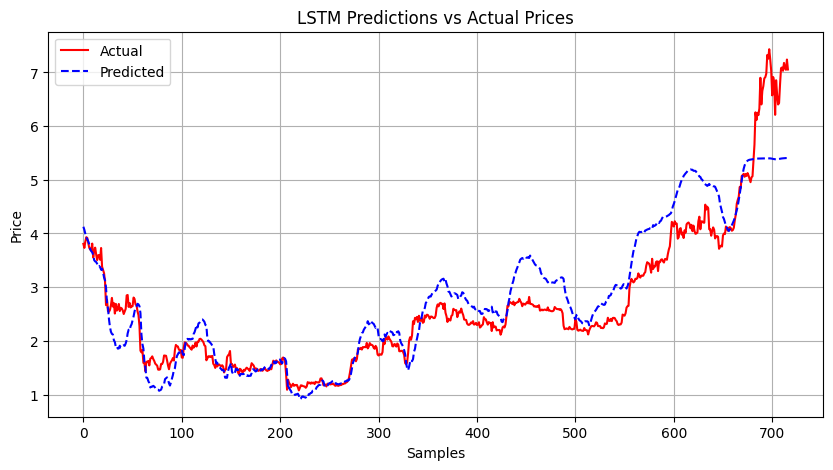

In [18]:
# plot predictions vs targets
plt.figure(figsize=(10, 5))
plt.plot(test_targets, label='Actual', color='red')
plt.plot(test_predictions, label='Predicted', color='blue', linestyle='--')
plt.xlabel('Samples')
plt.ylabel('Price')
plt.title('LSTM Predictions vs Actual Prices')
plt.legend()
plt.grid()
plt.show()